# Object Detection

## Importing Dependencies

In [117]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import cv2
import math
from PIL import Image
from google.protobuf import text_format
import platform
from protos import string_int_label_map_pb2

## Loading the Model

In [118]:
# Create cache folder
!mkdir .tmp

mkdir: .tmp: File exists


In [119]:
# Loads the modul from internet, unpacks it and initializes a Tensorflow saved model
def load_model(model_name):
    model_url = 'http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz'
    
    model_dir = tf.keras.utils.get_file(
        fname=model_name,
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    model = tf.saved_model.load(model_dir + '/saved_model')
    
    return model

In [120]:
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
saved_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [121]:
# Exploring model signatures
saved_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction pruned(inputs) at 0x7FF0167DAA30>})

In [122]:
# Loading default model signature
model = saved_model.signatures['serving_default']

## Loading Model Labels

In [123]:
def load_labels(labels_name):
    labels_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/' + labels_name
    
    labels_path = tf.keras.utils.get_file(
        fname=labels_name, 
        origin=labels_url,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    
    labels_file = open(labels_path, 'r')
    labels_string = labels_file.read()
    
    labels_map = string_int_label_map_pb2.StringIntLabelMap()
    try:
        text_format.Merge(labels_string, labels_map)
    except text_format.ParseError:
        labels_map.ParseFromString(labels_string)
    
    labels_dict = {}
    for item in labels_map.item:
        labels_dict[item.id] = item.display_name
    
    return labels_dict

In [124]:
LABELS_NAME = 'mscoco_label_map.pbtxt'
labels = load_labels(LABELS_NAME)
labels

8192/5056 [================================================] - 0s 0us/step


{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

## Exploring the Model

In [125]:
# List the model files
!ls -la .tmp/datasets/ssdlite_mobilenet_v2_coco_2018_05_09

total 81680
drwxr-x---  9 joonbo  staff       288 May 10  2018 .
drwxr-xr-x  6 joonbo  staff       192 Jul 20 16:29 ..
-rw-r-----  1 joonbo  staff        77 May 10  2018 checkpoint
-rw-r-----  1 joonbo  staff  19911343 May 10  2018 frozen_inference_graph.pb
-rw-r-----  1 joonbo  staff  18205188 May 10  2018 model.ckpt.data-00000-of-00001
-rw-r-----  1 joonbo  staff     17703 May 10  2018 model.ckpt.index
-rw-r-----  1 joonbo  staff   3665866 May 10  2018 model.ckpt.meta
-rw-r-----  1 joonbo  staff      4199 May 10  2018 pipeline.config
drwxr-x---  4 joonbo  staff       128 May 10  2018 saved_model


In [126]:
# Check model pipeline
!cat .tmp/datasets/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config

model {
  ssd {
    num_classes: 90
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
      use_depthwise: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold:

In [127]:
model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

In [128]:
model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

## Loading Test Images

In [129]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [130]:
TEST_IMAGES_DIR_PATH = pathlib.Path('data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('data/Bukayo-Saka-England-6.jpg'),
 PosixPath('data/IMG_7561.jpg'),
 PosixPath('data/IMG_7674_Original.jpg'),
 PosixPath('data/iStock-924858812.jpg'),
 PosixPath('data/im-331760.jpg')]

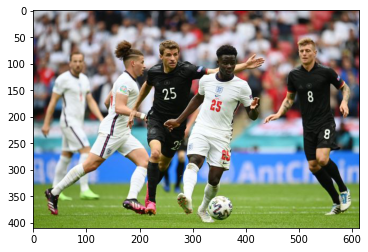

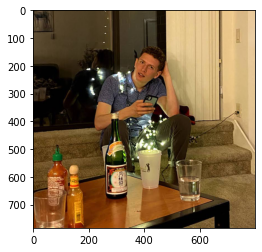

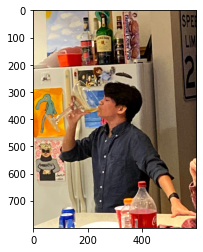

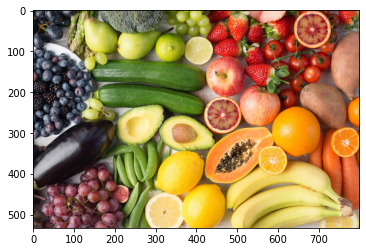

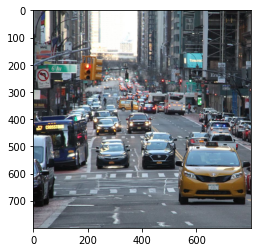

In [131]:
for image_path in TEST_IMAGE_PATHS:
    image_np = mpimg.imread(image_path)
    display_image(image_np)

## Running the Model

In [132]:
def detect_objects_on_image(image, model):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    
    # Adding one more dimension since model expect a batch of images
    input_tensor = input_tensor[tf.newaxis, ...]
    
    output_dict = model(input_tensor)
    
    num_detections = int(output_dict['num_detections'])
    output_dict = {
        key:value[0, :num_detections].numpy()
        for key,value in output_dict.items()
        if key != 'num_detections'
    }
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

In [133]:
def draw_detections_on_image(image, detections, labels):
    image_with_detections = image
    width, height, channels = image_with_detections.shape
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    label_padding = 5
    
    num_detections = detections['num_detections']
    if num_detections > 0:
        for detection_index in range(num_detections):
            detection_score = detections['detection_scores'][detection_index]
            detection_box = detections['detection_boxes'][detection_index]
            detection_class = detections['detection_classes'][detection_index]
            detection_label = labels[detection_class]
            detecion_label_full = detection_label + ' ' + str(math.floor(100 * detection_score)) + '%'
            
            y1 = int(width * detection_box[0])
            x1 = int(height * detection_box[1])
            y2 = int(width * detection_box[2])
            x2 = int(height * detection_box[3])
            
            # Detection rectangle
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x2, y2),
                color,
                3
            )
            
            # Label background
            label_size = cv2.getTextSize(
                detecion_label_full,
                cv2.FONT_HERSHEY_COMPLEX,
                0.7,
                2
            )
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1 - label_size[0][1] - 2 * label_padding),
                (x1 + label_size[0][0] + 2 * label_padding, y1),
                color,
                -1
            )
             
            # Label text
            cv2.putText(
                image_with_detections,
                detecion_label_full,
                (x1 + label_padding, y1 - label_padding),
                font, 
                0.7,
                (0, 0, 0),
                1, 
                cv2.LINE_AA
            )
            
    return image_with_detections

In [134]:
# Example of how detections dictionary looks like
image_np = np.array(Image.open(TEST_IMAGE_PATHS[1]))
detections = detect_objects_on_image(image_np, model)
detections

{'detection_classes': array([ 1, 44, 44,  1, 63, 47, 44, 67, 63, 47, 44]),
 'detection_boxes': array([[0.17336012, 0.2654682 , 0.6709838 , 0.70033276],
        [0.72557753, 0.15330711, 0.9942637 , 0.24098286],
        [0.6168684 , 0.06069428, 0.97693527, 0.15680698],
        [0.17739317, 0.12693   , 0.5368494 , 0.36203754],
        [0.4721701 , 0.6542043 , 0.9724976 , 0.9871134 ],
        [0.6948605 , 0.6547779 , 0.8896354 , 0.75772524],
        [0.47605538, 0.32332313, 0.85657895, 0.42829764],
        [0.5221275 , 0.00873905, 0.98754704, 0.9079649 ],
        [0.47816092, 0.40158725, 0.97558767, 0.96357596],
        [0.58917785, 0.46430394, 0.8397255 , 0.57198423],
        [0.7574722 , 0.03098712, 0.99470586, 0.15124147]], dtype=float32),
 'detection_scores': array([0.9911306 , 0.88860655, 0.81491953, 0.8144733 , 0.7832133 ,
        0.72829354, 0.7032392 , 0.6673501 , 0.50395256, 0.46754187,
        0.31458032], dtype=float32),
 'num_detections': 11}

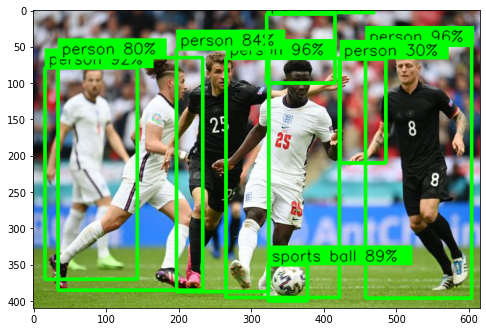

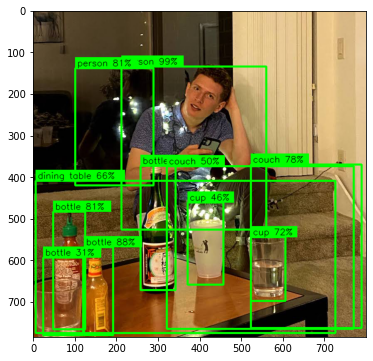

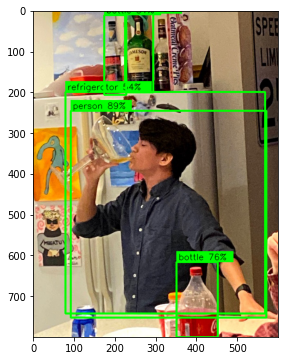

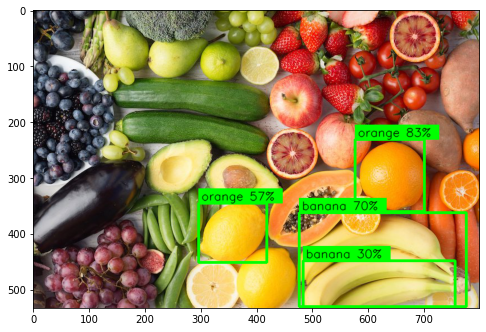

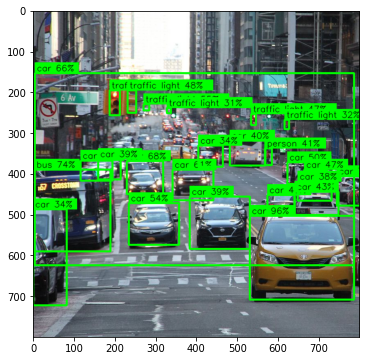

In [135]:
for image_path in TEST_IMAGE_PATHS:
    image_np = np.array(Image.open(image_path))
    detections = detect_objects_on_image(image_np, model)
    image_with_detections = draw_detections_on_image(image_np, detections, labels)
    plt.figure(figsize=(8,6))
    plt.imshow(image_with_detections)